# Semi-automatic KG Ontology for QM FAQ
- **Main Goal**
  - This notebook semi-auttomatically creates the KG using a pre-built JSON file. Also the JSON can be iteratively improvised by visualizing the KG in Neo4j as explained below.
  - The KG uses Neo4j Graph DB that contains both triplets (subject, relattion, object) and DocumentChunk nodes (raw chunks with chunk embeddings), with a MENTIONS relation connecting DocumentChunk nodes to the entity nodes mentioned in it.
  - The KG also needs a vector index on the chunk embeddings for similarity search. For now, it is based on cosine similarity, but it can be improved by combining dense (e.g., cosine similarity) and sparse (e.g., BM25) similarity metrics by updating the CQL query.
  - This HybridRAG pipeline formats the context of the prompt by finding the top-k chunks by Vector Search on Neo4j Chunk Embedding Index, then finds the triplets that has some node(s) mentioned in the Chunk and the 1-hop neighbours of these nodes.
- **Pre-processing steps to create JSON of triplets** [Diagram Given below]:
  - Summarize each section (1-2 paragraphs) using the Prompt-V3_1.
  - Turned a 30-page PDF into 4-pages Summary PDF.
  - Highlighted some of the selected sentences from the Summary PDF.
  - Take each of the selected sentences from the Summary PDF and give the Prompt-V3_2.
  - Analyse manually to be consistent with the 4-step verification.
- **JSON format**:
  - This is a sample of the JSON format used here for the triplets.
  - {
    "raw_sentence": "The time-dependent wave function, $\Psi(x,t)$, is determined by the Hamiltonian operator, $\hat{H}$.",
    "suggested_triplets": [{
      "subject_name": "time-dependent wave function",
      "subject_class": "Mathematical_Object",
      "relationship": "IS_DETERMINED_BY",
      "object_name": "Hamiltonian operator",
      "object_class": "Operator"
    },
    }]

- **Important steps in this implementation for converting the JSON into Neo4j GraphDB**:
  - Neo4j Util Functions to get credentials and driver.
  - Delete existing Graph and Indexes in Neo4j Graph DB.
  - Add triplets from JSON into Neo4j Graph DB.
  - Add DocumentChunk nodes with raw chunks in the "text" attribute and chunk embedding in the "embedding" attribute, and a MENTIONS relation connecting DocumentChunk node to all the nodes mentioned in it.
  - Add a vector index on the "embedding" attribute of all the DocumentChunk nodes.
  - After One round of this entire process some issues like disconnected islands were found and it was manually fixed in the JSON itself as mentioned in the later part of this notebook. After the JSON was updated, this notebook was run again. A few repetitions in this way gave the final KG.

- **KG Visualizations**: 2 Important visualizations are given here:
  1. Final KG before adding the DocumentChunk nodes and MENTIONS relations. How the disconnected components relates to different sub-topics as shown here.
  2. Final KG after adding the DocumentChunk nodes and MENTIONS relations. How the entire KG became more connected in this way as shown here.

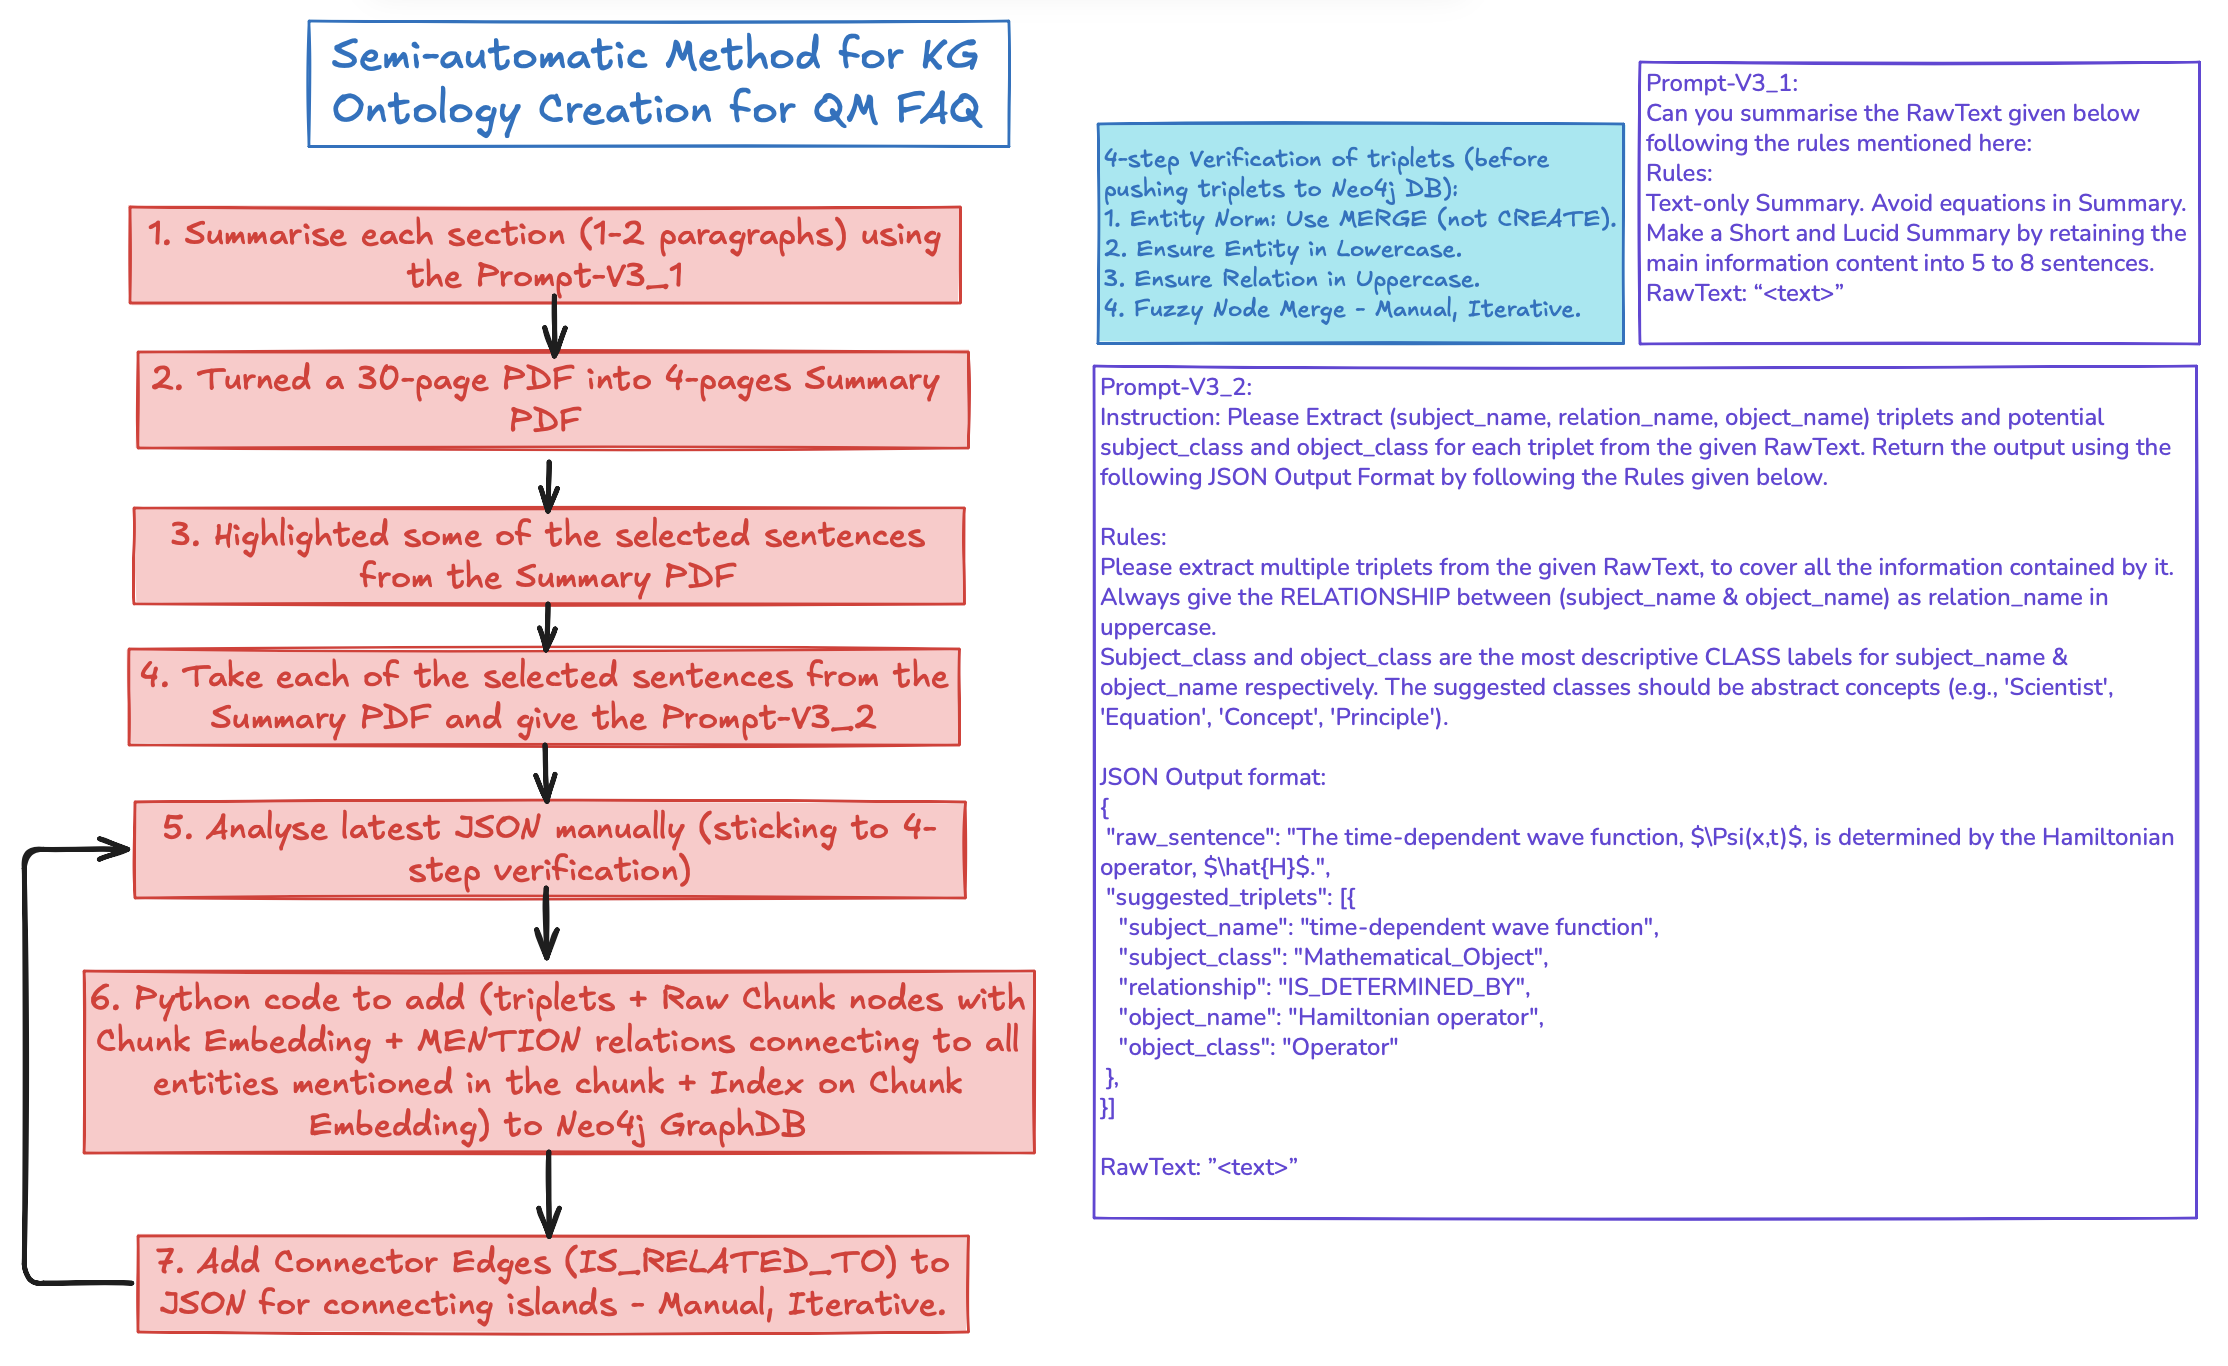

### Installation

In [ ]:
!pip install neo4j

### Imports

In [ ]:
import os
import json
from neo4j import GraphDatabase
from sentence_transformers import SentenceTransformer

### CONFIG

In [ ]:
DATA_PATH = ""
DO_CREATE_DOC_NODE = True
DO_HUBNODE_POST_PROCESS = False
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
RESPONSE_MODEL_NAME = "gpt-3.5-turbo"

VECTOR_INDEX_NAME = "QM_Embedding"
FULLTEXT_INDEX_NAME = "QM_Fulltext"

### Neo4j API Keys

In [ ]:
from google.colab import userdata, drive
NEO4J_URI = userdata.get('NEO4J_URI')
NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD')
DATA_PATH = userdata.get("QM_DATA_PATH")

### Access Docs from Drive

In [ ]:
# --- Mount Google Drive ---
# This allows the script to access your PDF file from Google Drive.
import time
drive.mount('/content/drive')
print("Google Drive mounted successfully.")
time.sleep(10)

In [ ]:
import glob
qm_json_path_arr = glob.glob(os.path.join(DATA_PATH, "*.json"))
print(qm_json_path_arr)
json_path = qm_json_path_arr[0]

In [ ]:
with open(json_path, 'r') as file:
    data = json.load(file)
print(data)

In [ ]:
# print(data["all_triplets_by_sent"][0])

print(data["all_triplets_by_sent"][40])
no_triplets = len(data["all_triplets_by_sent"])
print(no_triplets)
for i in range(no_triplets):
    raw_sent = data["all_triplets_by_sent"][i]["raw_sentence"]
    no_triplets_per_sent = len(data["all_triplets_by_sent"][i]["suggested_triplets"])
    print(f"RAW_SENT: {raw_sent}")
    print(f"NO_TRIPETS IN RAW_SENT: {no_triplets_per_sent}")

### Neo4j Util Functions

In [ ]:
def get_neo4j_credentials():
    return NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD

## Funttion to get Neo4j DB driver
def get_driver():
    """Creates a Neo4j driver instance."""
    uri, user, password = get_neo4j_credentials()
    return GraphDatabase.driver(uri, auth=(user, password), max_connection_lifetime=3600)

### Add triplets from JSON to Neo4j Dataset

In [ ]:
driver = get_driver()
print(data["all_triplets_by_sent"][40])
no_triplets = len(data["all_triplets_by_sent"])
print(no_triplets)

In [ ]:
# Delete the previously exiting Neo4j DB
relation_delete_query = "MATCH ()-[r]->() DELETE r;"
node_delete_query = "MATCH (n) DETACH DELETE n;"
# query = f"{relation_delete_query} {node_delete_query}"
with driver.session() as session:
    session.run(relation_delete_query)
with driver.session() as session:
    session.run(node_delete_query)

In [ ]:
# Delete Vector Index
vector_index_del_query = f"DROP INDEX {VECTOR_INDEX_NAME} IF EXISTS"
with driver.session() as session:
    session.run(vector_index_del_query)

In [ ]:
# Add triplets from JSON to Neo4j

for i in range(no_triplets):
    raw_sent = data["all_triplets_by_sent"][i]["raw_sentence"]
    no_triplets_per_sent = len(data["all_triplets_by_sent"][i]["suggested_triplets"])
    triplet_arr_per_sent = data["all_triplets_by_sent"][i]["suggested_triplets"]
    print(f"RAW_SENT: {raw_sent}")

    for triplet in triplet_arr_per_sent:
        subject_name = triplet["subject_name"]
        object_name = triplet["object_name"]
        subject_class = triplet["subject_class"]
        object_class = triplet["object_class"]
        relation = triplet["relationship"]

        print(f"subject_class = {subject_class}")
        print(f"subject_name = {subject_name}")
        print(f"object_class = {object_class}")
        print(f"object_name = {object_name}")
        print(f"relation = {relation}")

        # Check & Pass if Relation name is all Caital Letters [convert to UPPERCASE]
        relation = relation.upper()
        # Check & Pass if Subject class and Object class does not contain any space [replace space with underscore]
        subject_name = subject_name.lower()
        object_name = object_name.lower()
        subject_class = subject_class.replace(" ", "_")
        object_class = object_class.replace(" ", "_")

        query = f"""
        MERGE (s:{subject_class} {{name: $subj_name}})
        MERGE (o:{object_class} {{name: $obj_name}})
        MERGE (s)-[r:{relation}]->(o)
        RETURN s, r, o
        """
        # These are the values safely passed to Neo4j
        parameters = {
            "subj_name": subject_name,
            "obj_name": object_name
        }
        with driver.session() as session:
            result = session.run(query, **parameters)
            print("Successfully created triplet:")
            for record in result:
                print(f"({record['s']['name']})-[:{relation}]->({record['o']['name']})")

    print(f"Added {no_triplets_per_sent} triplets to Neo4j")
    print("=======================================================")

### Adding DocumentChunk Node with (Raw Sent + Embedding) to Neo4j & Connecting the DocumentChunk Node with Subject and Object Nodes Present within the Raw Sent (Considering 1 Sent = 1 Chunk) using MENTIONS relation

In [ ]:
# Adding Document

if DO_CREATE_DOC_NODE == True:
    embedding_model = SentenceTransformer(EMB_MODEL_NAME)

    for i in range(no_triplets):
        raw_sent = data["all_triplets_by_sent"][i]["raw_sentence"]
        raw_sent_embedding = embedding_model.encode(raw_sent, convert_to_tensor=False)
        no_triplets_per_sent = len(data["all_triplets_by_sent"][i]["suggested_triplets"])
        triplet_arr_per_sent = data["all_triplets_by_sent"][i]["suggested_triplets"]
        print(f"RAW_SENT: {raw_sent}")

        parameters = {
            "raw_sent": raw_sent,
            "raw_sent_embedding": raw_sent_embedding
        }
        doc_node_query = """MERGE (c:DocumentChunk {text: $raw_sent, embedding: $raw_sent_embedding})"""
        with driver.session() as session:
            session.run(doc_node_query, **parameters)

        for triplet in triplet_arr_per_sent:
            subject_name = triplet["subject_name"]
            object_name = triplet["object_name"]
            subject_class = triplet["subject_class"]
            object_class = triplet["object_class"]
            relation = triplet["relationship"]

            print(f"subject_class = {subject_class}")
            print(f"subject_name = {subject_name}")
            print(f"object_class = {object_class}")
            print(f"object_name = {object_name}")
            print(f"relation = {relation}")

            # Check & Pass if Relation name is all Caital Letters [convert to UPPERCASE]
            relation = relation.upper()
            # Check & Pass if Subject class and Object class does not contain any space [replace space with underscore]
            subject_name = subject_name.lower()
            object_name = object_name.lower()
            subject_class = subject_class.replace(" ", "_")
            object_class = object_class.replace(" ", "_")

            parameters = {
                "raw_sent": raw_sent,
                "subject_name": subject_name
            }
            doc_node_subject_node_relation_query = f"""
                MATCH (c:DocumentChunk {{text: $raw_sent}})
                MATCH (p:{subject_class} {{name: $subject_name}})
                MERGE (c)-[:MENTIONS]->(p)
                """
            with driver.session() as session:
                session.run(doc_node_subject_node_relation_query, **parameters)

            parameters = {
                "raw_sent": raw_sent,
                "object_name": object_name
            }
            doc_node_object_node_relation_query = f"""
                MATCH (c:DocumentChunk {{text: $raw_sent}})
                MATCH (p:{object_class} {{name: $object_name}})
                MERGE (c)-[:MENTIONS]->(p)
                """
            with driver.session() as session:
                session.run(doc_node_object_node_relation_query, **parameters)

        print(f"Connected {no_triplets_per_sent} triplets to the Raw Sent DocumentChunk Node in Neo4j")
        print("=======================================================")

### Create VECTOR_INDEX on the Embeddings of DocumentChunk Nodes
- This is meant for the RAG to find out the related chunks from the KG first.
- Then from the related chunks we can take all the triplets with mentioned entties and the the corresponding 1-hop neighbours of them.

In [ ]:
def create_vector_index(driver, vector_dim=384):
    # The Cypher query to create the index
    # Note: 1536 is the dimension size for OpenAI embeddings (text-embedding-3-small / ada-002)
    # If you are using a different model (e.g., HuggingFace), change this number!
    query = f"""
    CREATE VECTOR INDEX {VECTOR_INDEX_NAME} IF NOT EXISTS
    FOR (n:DocumentChunk)
    ON (n.embedding)
    OPTIONS {{indexConfig: {{
      `vector.dimensions`: {vector_dim},
      `vector.similarity_function`: 'cosine'
    }}}}
    """

    print(f"Creating vector index: '{VECTOR_INDEX_NAME}'...")
    try:
        with driver.session() as session:
            session.run(query)
        print("Success! Index created. You can now run the Hybrid RAG code.")
    except Exception as e:
        print(f"Error creating index: {e}")

In [ ]:
if DO_CREATE_DOC_NODE == True:
    create_vector_index(driver)

### The Resulting KG after performing the Post-processing steps to fix the below mentioned issues (without Raw Chunks and Chunk Embeddings Added to the KG in Neo4j DB):
**Issues**:
1. For few node pairs (not many) there are multiple relations between the same pair of nodes.
2. There are some big clusters of densely connected nodes. Each of big cluster connects to a specific sub-topic in the PDF. But there were many small disconnected components also in the KG.

Issue (1) can be a feature also sometimes, but we need to check it thoroughly if it is noise. Issue (2) is a serious issue for multi-hop queries. Practical post-processing steps to take here:

**Remedies**:
1. Node Normalization: Check if multiple different nodes mean the same thing, and fix them in the JSON - Manual, Iterative..
2. Add Connector Edges (IS_RELATED_TO) to JSON for connecting islands, and fix them in the JSON - Manual, Iterative.

The following KG is the o/p after performing the above mentioned Remedey steps but without connecting the raw chunks and raw chunk embedding to the nodes mentioned in the chunk.

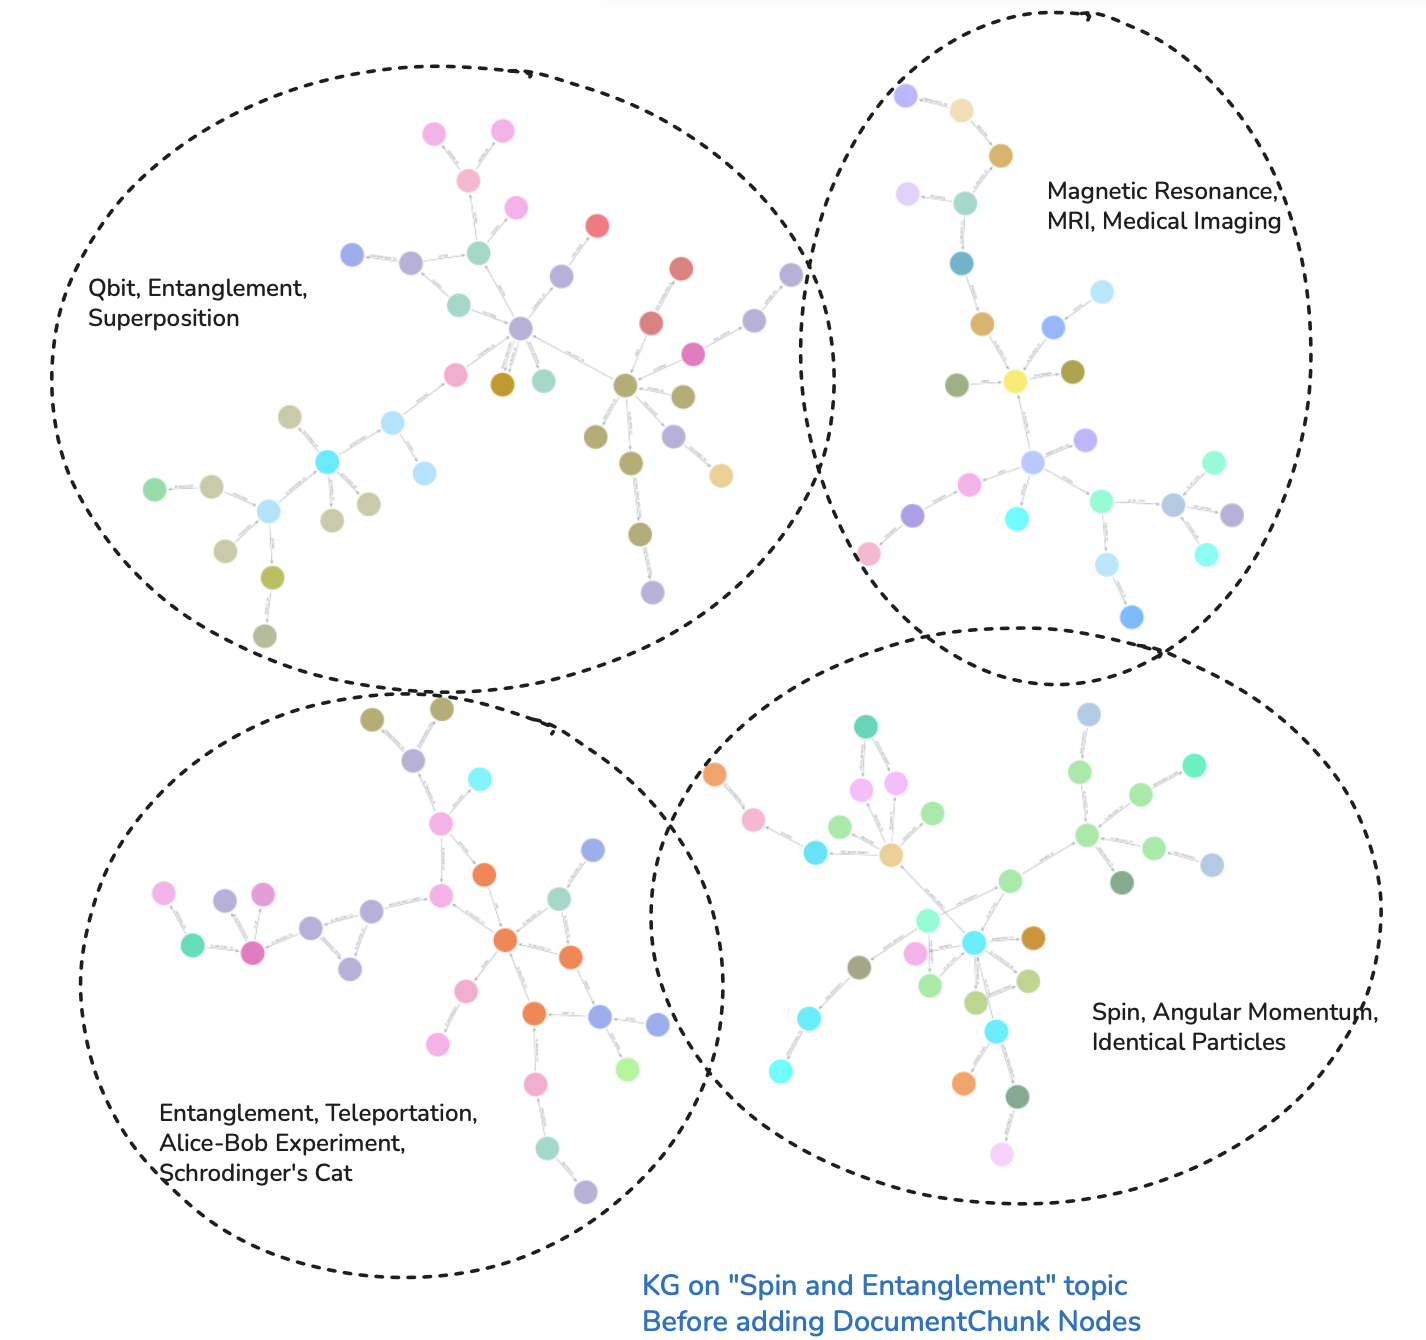

### Resulting KG after adding (Triplets + Raw Chunks + Chunk Embeddings + MENTIONS relations) to the KG in Neo4j DB
- This KG has all the triplets from the latest JSON and the raw sentences as DocumentChunk nodes.
- This KG also has MENTIONS relation from each of the DocumentChunk node to all the entities mentioned in the chunk.
- Now the KG does have much less of disconnection issue as before without adding the raw chunks and MENTIONS relations.

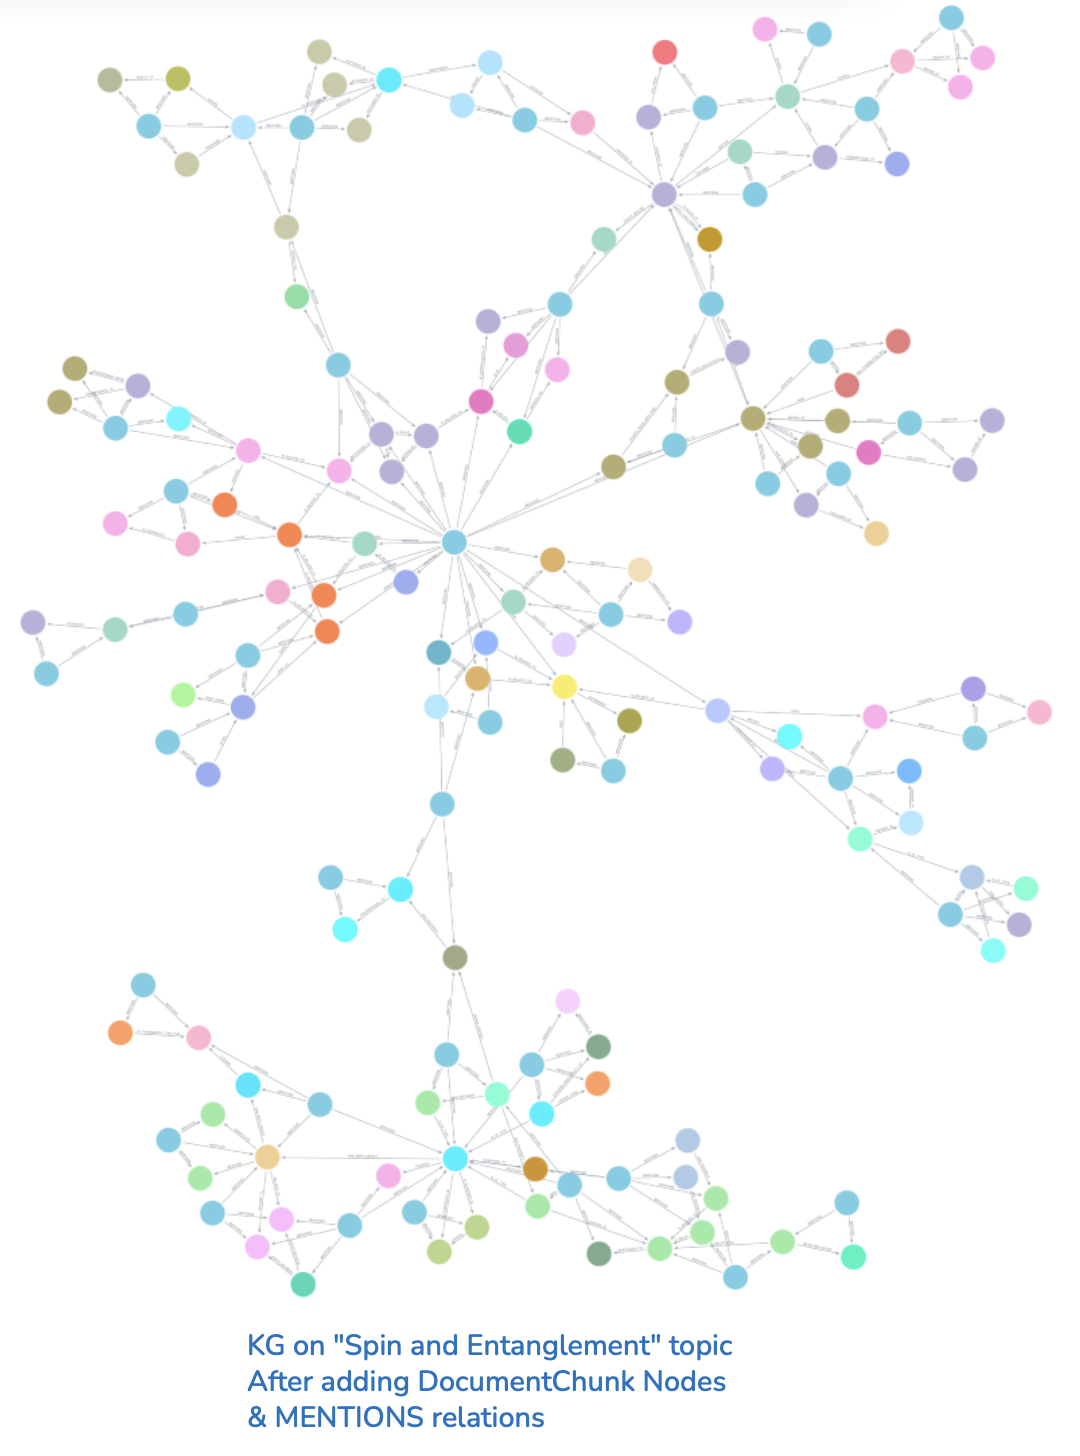